In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pathlib
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing
import lightgbm

In [145]:
currentDir = pathlib.Path().resolve()
compeTitleDir = currentDir.parent

# 使用データのディレクトリ名指定
usedDataDir = 'original'
dataDir = str(compeTitleDir) + f'/LocalData/{usedDataDir}'
train_csv = dataDir + '/train.csv'
test_csv = dataDir + '/test.csv'

In [146]:
df_train = pd.read_csv(train_csv)
df_test_sub = pd.read_csv(test_csv)
print(df_train.shape, df_test_sub.shape)
df_train

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [147]:
le = preprocessing.LabelEncoder()

train_idx = df_train.shape[0]
test_idx = df_test_sub.shape[0]

df_all = pd.concat([df_train, df_test_sub])

# LGBMRegressorは特徴量として、int, float, booleanのみ有効なのでカテゴリ変数をエンコード
def encoder(dataframe):
    for column in dataframe.columns:
        if dataframe[column].dtype == 'object':
            targetCol = dataframe[column]
            encodedCol = le.fit_transform(targetCol)
        else:
            continue
        dataframe[column] = pd.Series(encodedCol)
    return dataframe

df_all = encoder(df_all)

df_train = df_all.iloc[:train_idx, :]
df_test_sub = df_all.iloc[train_idx:, :]
df_test_sub = df_test_sub.dropna(how='all', axis=1)
df_test_sub

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,3,80.0,11622,1,2,3,3,0,...,120,0,3,4,4,0,6,2010,8,4
1,1462,20,3,81.0,14267,1,2,3,3,0,...,0,0,3,4,4,12500,6,2010,8,4
2,1463,60,3,74.0,13830,1,2,0,3,0,...,0,0,3,4,4,0,3,2010,8,4
3,1464,60,3,78.0,9978,1,2,0,3,0,...,0,0,3,4,4,0,6,2010,8,0
4,1465,120,3,43.0,5005,1,2,0,3,0,...,144,0,3,4,4,0,1,2010,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,1,21.0,1936,1,1,3,3,0,...,0,0,3,4,4,0,6,2006,8,4
1455,2916,160,3,21.0,1894,1,2,3,3,0,...,0,0,3,4,4,0,4,2006,8,4
1456,2917,20,3,160.0,20000,1,2,3,3,0,...,0,0,3,2,4,0,9,2006,8,4
1457,2918,85,3,62.0,10441,1,2,3,3,0,...,0,0,3,0,2,700,7,2006,8,4


In [148]:
df_train_x = df_train.iloc[:, :-1]
df_train_y = df_train.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(df_train_x, df_train_y, test_size=0.2, random_state=0)

In [149]:
regressor = lightgbm.LGBMRegressor()

model = regressor.fit(x_train, y_train)
y_predicted = model.predict(x_test)

Text(0, 0.5, 'Predicted data')

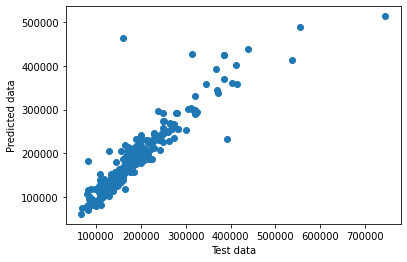

In [150]:
plt.scatter(y_test, y_predicted)
plt.xlabel('Test data')
plt.ylabel('Predicted data')

In [151]:
# 検証用のテストデータによる精度確認
r2 = r2_score(y_test, y_predicted)
rmse = np.sqrt(mean_squared_error(y_test, y_predicted))
print(r2, '\n', rmse)

0.8464188522541181 
 32566.982722268353


In [152]:
# テストデータに対して予測
y_test_predicted = model.predict(df_test_sub)

In [153]:
df_test_sub_id = df_test_sub.loc[:, 'Id']
df_predict = pd.DataFrame(pd.Series(y_test_predicted), columns=['SalePrice'])
df_submission = pd.concat([df_test_sub_id, df_predict], axis=1)
df_submission

,Id,SalePrice
0,1461,128627.044022
1,1462,148262.929221
2,1463,197642.439681
3,1464,188852.094479
4,1465,181228.386483
...,...,...
1454,2915,84476.336088
1455,2916,86388.035831
1456,2917,180500.272091
1457,2918,114835.094459


In [154]:
df_submission.to_csv(str(compeTitleDir) + '/submissions/sub_ver1.csv', index=False)